In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
df = pd.read_csv('data/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df.shape

(101766, 50)

In [4]:
# pandas_profiling.ProfileReport(df)

In [5]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [6]:
# look at a count of missing (?) values in the dataset
for col in df.columns:
    if df[col].dtype == object:
        if df[col][df[col] == '?'].count() != 0:
            print(col,df[col][df[col] == '?'].count(),(df[col][df[col] == '?'].count()/101766)*100)
            
# gender was coded differently so we use a custom count for this one
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count(),
      (df['gender'][df['gender'] == 'Unknown/Invalid'].count()/101766)*100)

race 2273 2.2335554114340743
weight 98569 96.85847925633315
payer_code 40256 39.5574160328597
medical_specialty 49949 49.08220820313268
diag_1 21 0.02063557573256294
diag_2 358 0.3517874339170253
diag_3 1423 1.398305917497003
gender 3 0.002947939390366134


Weight is missing in over 96% of records in the dataset. Probably should drop this entire column since there are very few records that actually have data.

Also, Payer Code and Medical Specialty of the physician are missing 40-50% of the time. I am going to drop these columns from the dataset as well, although I may revisit this in the future since it would be interesting to see the effect that these values have on readmissions.

In [7]:
# dropping weight, payer_code, and medical_specialty from the dataset
df.drop(['weight', 'payer_code', 'medical_specialty'], axis = 1, inplace=True)

# check the column count
df.shape

(101766, 47)

In [8]:
# dropping records where gender is missing
df = df[df.gender != 'Unknown/Invalid']

# check the row count
df.shape

(101763, 47)

In [9]:
def diag_missing_label(row):
    """This function will return a 1 if all diag attributes are missing"""
    
    if row['diag_1'] == '?' and row['diag_2'] == '?' and row['diag_3'] == '?':
        return 1
    else:
        return 0

In [10]:
# apply function to return a 1 if all diag attributes
df['diag_missing_label'] = df.apply(lambda row: diag_missing_label(row), axis=1)

In [11]:
df['diag_missing_label'].value_counts()

0    101762
1         1
Name: diag_missing_label, dtype: int64

In [12]:
# drop records where all diag attributes are missing
df = df[df.diag_missing_label != 1]

df.shape

(101762, 48)

In [13]:
df.discharge_disposition_id.value_counts()

1     60232
3     13954
6     12902
18     3691
2      2128
22     1992
11     1642
5      1184
25      989
4       815
7       623
23      412
13      398
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

In [14]:
# drop records where discharge disposition = 11 (patient died)
df = df[df.discharge_disposition_id != 11]

df.shape

(100120, 48)

In [15]:
# are there multiple records per patient id?
df.patient_nbr.nunique()

70442

In [16]:
# drop duplicates of patient id to match assumption of logistic regression model
df.drop_duplicates('patient_nbr', inplace=True)

df.shape

(70442, 48)

In [17]:
def get_unique_values(df):
    """This function will print out number of unique values for each column in the dataset"""
    
    for col in df.columns:
        print(str(col), df[col].nunique())

In [18]:
get_unique_values(df)

encounter_id 70442
patient_nbr 70442
race 6
gender 2
age 10
admission_type_id 8
discharge_disposition_id 25
admission_source_id 17
time_in_hospital 14
num_lab_procedures 116
num_procedures 7
num_medications 75
number_outpatient 33
number_emergency 18
number_inpatient 13
diag_1 696
diag_2 725
diag_3 758
number_diagnoses 16
max_glu_serum 4
A1Cresult 4
metformin 4
repaglinide 4
nateglinide 4
chlorpropamide 4
glimepiride 4
acetohexamide 2
glipizide 4
glyburide 4
tolbutamide 2
pioglitazone 4
rosiglitazone 4
acarbose 3
miglitol 4
troglitazone 2
tolazamide 2
examide 1
citoglipton 1
insulin 4
glyburide-metformin 4
glipizide-metformin 2
glimepiride-pioglitazone 1
metformin-rosiglitazone 2
metformin-pioglitazone 2
change 2
diabetesMed 2
readmitted 3
diag_missing_label 1


There are four columns that only have 1 value for all records. These cannot provide any reliable information for predicting readmission, so let's drop the following columns:

examide, citoglipton, glimepiride-pioglitazone, diag_missing_label (which was created above)

In [19]:
# drop the four columns that only have 1 value for all records
df.drop(['examide', 'citoglipton', 'glimepiride-pioglitazone', 'diag_missing_label'], axis=1, inplace=True)

df.shape

(70442, 44)

### Feature Engineering

In [20]:
# create a column for service utilization
df['service_utilization'] = df.number_outpatient + df.number_emergency + df.number_inpatient

In [21]:
df.sort_values(by='service_utilization', ascending=False).head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization
32661,103948200,42466248,Caucasian,Female,[30-40),1,1,7,3,45,0,14,3,42,4,250.11,346,311,5,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Yes,>30,49
64743,180134730,85551867,Caucasian,Male,[80-90),1,6,7,3,9,0,18,42,0,0,428,427,799,9,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30,42
86135,273615240,90847035,Caucasian,Male,[40-50),1,1,7,1,58,1,8,0,37,0,780,304,722,9,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Ch,Yes,NO,37
67249,188678112,88598556,Caucasian,Female,[60-70),5,2,1,1,5,1,25,36,0,0,410,599,427,9,None,>8,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,NO,36
32601,103784028,23491422,Caucasian,Male,[80-90),5,6,17,6,19,2,14,35,0,0,426,428,425,7,>200,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,Ch,Yes,NO,35


Service utilization looks to be higher for older patients and therefore is likely associated with more readmissions. This could be a good predictor of readmissions, although hard to tell if these are because of diabetes or because of other complications due to older age.

In [22]:
meds = ['metformin',
'repaglinide',
'nateglinide',
'chlorpropamide',
'glimepiride',
'acetohexamide',
'glipizide',
'glyburide',
'tolbutamide',
'pioglitazone',
'rosiglitazone',
'acarbose',
'miglitol',
'troglitazone',
'tolazamide',
'insulin',
'glyburide-metformin',
'glipizide-metformin',
'metformin-rosiglitazone',
'metformin-pioglitazone',]



df['num_diabetes_meds'] = 0
for med in meds:
    colname = str(med) + 'temp'
    df[colname] = df[med].apply(lambda x: 0 if x == 'No' else 1)
    df['num_diabetes_meds'] = df['num_diabetes_meds'] + df[colname]
    del(df[colname])

In [23]:
df.num_diabetes_meds.value_counts()

1    31372
0    16829
2    15503
3     5680
4     1004
5       50
6        4
Name: num_diabetes_meds, dtype: int64

Most patients were either not on medications or were taking one medication during their visit. However, there are still over 1,000 patients that were taking two or more medications. I will be using the number of medications as one of the features to predict readmissions.

In [24]:
df.diabetesMed.value_counts()

Yes    53613
No     16829
Name: diabetesMed, dtype: int64

In [25]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,num_diabetes_meds
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,>30,0,1
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,3,1
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,NO,0,1
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Ch,Yes,NO,0,2


Now looking at diagnoses codes, it appears I need to clean the data. There are several question marks ('?') in these columns, which probably represent null or missing values.

In [26]:
print("There are: " + str(len(df[df["diag_1"] == "?"])) + " rows where diag_1 = ?")
print("There are: " + str(len(df[df["diag_2"] == "?"])) + " rows where diag_2 = ?")
print("There are: " + str(len(df[df["diag_3"] == "?"])) + " rows wehre diag_3 = ?")

There are: 10 rows where diag_1 = ?
There are: 293 rows where diag_2 = ?
There are: 1224 rows wehre diag_3 = ?


Because there are several rows that have question marks ('?') indicating missing values, I will keep these records in the dataset. I will code them separately from the rest of the data - perhaps using a '-1' to represent 'missing.'

In [27]:
# create copies of the 3 diagnosis columns
df['level1_diag'] = df['diag_1']
df['level2_diag'] = df['diag_2']
df['level3_diag'] = df['diag_3']

# deal with the missing values first
df['level1_diag'] = df['level1_diag'].replace('?', -1)
df['level2_diag'] = df['level2_diag'].replace('?', -1)
df['level3_diag'] = df['level3_diag'].replace('?', -1)

# when V or E is at beginning of diagnosis code, recode as 'Other'
df.loc[df['diag_1'].str.contains('V'), ['level1_diag']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag']] = 0
df.loc[df['diag_2'].str.contains('V'), ['level2_diag']] = 0
df.loc[df['diag_2'].str.contains('E'), ['level2_diag']] = 0
df.loc[df['diag_3'].str.contains('V'), ['level3_diag']] = 0
df.loc[df['diag_3'].str.contains('E'), ['level3_diag']] = 0

In [28]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,num_diabetes_meds,level1_diag,level2_diag,level3_diag
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,250.83,-1,-1
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,>30,0,1,276,250.01,255
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,3,1,648,250,0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,NO,0,1,8,250.43,403
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Ch,Yes,NO,0,2,197,157,250


In [29]:
# change new diagnosis columns to int
df['level1_diag'] = df['level1_diag'].astype(float)
df['level2_diag'] = df['level2_diag'].astype(float)
df['level3_diag'] = df['level3_diag'].astype(float)

In [30]:
# level1_diagnosis recoding
for index, row in df.iterrows():
    if (row['level1_diag'] >= 390 and row['level1_diag'] <= 459) or (np.floor(row['level1_diag']) == 785):
        df.loc[index, 'level1_diag'] = 1
    elif (row['level1_diag'] >= 460 and row['level1_diag'] <= 519) or (np.floor(row['level1_diag']) == 786):
        df.loc[index, 'level1_diag'] = 2
    elif (row['level1_diag'] >= 520 and row['level1_diag'] <= 579) or (np.floor(row['level1_diag']) == 787):
        df.loc[index, 'level1_diag'] = 3
    elif np.floor(row['level1_diag']) == 250:
        df.loc[index, 'level1_diag'] = 4
    elif (row['level1_diag'] >= 800 and row['level1_diag'] <= 999):
        df.loc[index, 'level1_diag'] = 5
    elif (row['level1_diag'] >= 710 and row['level1_diag'] <= 739):
        df.loc[index, 'level1_diag'] = 6
    elif (row['level1_diag'] >= 580 and row['level1_diag'] <= 629) or (np.floor(row['level1_diag']) == 788):
        df.loc[index, 'level1_diag'] = 7
    elif (row['level1_diag'] >= 140 and row['level1_diag'] <= 239):
        df.loc[index, 'level1_diag'] = 8
    else:
        df.loc[index, 'level1_diag'] = 0

In [31]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,num_diabetes_meds,level1_diag,level2_diag,level3_diag
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,4.0,-1.00,-1.0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,>30,0,1,0.0,250.01,255.0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,3,1,0.0,250.00,0.0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,NO,0,1,0.0,250.43,403.0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Ch,Yes,NO,0,2,8.0,157.00,250.0


In [32]:
# repeat recoding step above for levels 2 and 3 diagnosis

# level2_diagnosis recoding
for index, row in df.iterrows():
    if (row['level2_diag'] >= 390 and row['level2_diag'] <= 459) or (np.floor(row['level2_diag']) == 785):
        df.loc[index, 'level2_diag'] = 1
    elif (row['level2_diag'] >= 460 and row['level2_diag'] <= 519) or (np.floor(row['level2_diag']) == 786):
        df.loc[index, 'level2_diag'] = 2
    elif (row['level2_diag'] >= 520 and row['level2_diag'] <= 579) or (np.floor(row['level2_diag']) == 787):
        df.loc[index, 'level2_diag'] = 3
    elif np.floor(row['level2_diag']) == 250:
        df.loc[index, 'level2_diag'] = 4
    elif (row['level2_diag'] >= 800 and row['level2_diag'] <= 999):
        df.loc[index, 'level2_diag'] = 5
    elif (row['level2_diag'] >= 710 and row['level2_diag'] <= 739):
        df.loc[index, 'level2_diag'] = 6
    elif (row['level2_diag'] >= 580 and row['level2_diag'] <= 629) or (np.floor(row['level2_diag']) == 788):
        df.loc[index, 'level2_diag'] = 7
    elif (row['level2_diag'] >= 140 and row['level2_diag'] <= 239):
        df.loc[index, 'level2_diag'] = 8
    else:
        df.loc[index, 'level2_diag'] = 0
        
# level3_diagnosis recoding
for index, row in df.iterrows():
    if (row['level3_diag'] >= 390 and row['level3_diag'] <= 459) or (np.floor(row['level3_diag']) == 785):
        df.loc[index, 'level3_diag'] = 1
    elif (row['level3_diag'] >= 460 and row['level3_diag'] <= 519) or (np.floor(row['level3_diag']) == 786):
        df.loc[index, 'level3_diag'] = 2
    elif (row['level3_diag'] >= 520 and row['level3_diag'] <= 579) or (np.floor(row['level3_diag']) == 787):
        df.loc[index, 'level3_diag'] = 3
    elif np.floor(row['level3_diag']) == 250:
        df.loc[index, 'level3_diag'] = 4
    elif (row['level3_diag'] >= 800 and row['level3_diag'] <= 999):
        df.loc[index, 'level3_diag'] = 5
    elif (row['level3_diag'] >= 710 and row['level3_diag'] <= 739):
        df.loc[index, 'level3_diag'] = 6
    elif (row['level3_diag'] >= 580 and row['level3_diag'] <= 629) or (np.floor(row['level3_diag']) == 788):
        df.loc[index, 'level3_diag'] = 7
    elif (row['level3_diag'] >= 140 and row['level3_diag'] <= 239):
        df.loc[index, 'level3_diag'] = 8
    else:
        df.loc[index, 'level3_diag'] = 0

In [33]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,num_diabetes_meds,level1_diag,level2_diag,level3_diag
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,0,4.0,0.0,0.0
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,>30,0,1,0.0,4.0,0.0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,3,1,0.0,4.0,0.0
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,Ch,Yes,NO,0,1,0.0,4.0,1.0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,Ch,Yes,NO,0,2,8.0,8.0,4.0


In [34]:
# check to see that the codes are correct for each diag level
df[['diag_1', 'level1_diag']].head(10).T

,0,1,2,3,4,5,6,7,8,9
diag_1,250.83,276,648,8,197,414,414,428,398,434
level1_diag,4,0,0,0,8,1,1,1,1,1


In [35]:
df[['diag_2', 'level2_diag']].head(10).T

,0,1,2,3,4,5,6,7,8,9
diag_2,?,250.01,250,250.43,157,411,411,492,427,198
level2_diag,0,4,4,4,8,1,1,2,1,8


In [36]:
df[['diag_3', 'level3_diag']].head(10).T

,0,1,2,3,4,5,6,7,8,9
diag_3,?,255,V27,403,250,250,V45,250,38,486
level3_diag,0,0,0,1,4,4,0,4,0,2


Now that we have recoded diagnoses, let's look at other columns that need recoding. In order to generate the model, I need to recode all string variables to binary or integer values.

In [37]:
# let's take a look at the race column
df.race.value_counts()

Caucasian          52672
AfricanAmerican    12693
?                   1920
Hispanic            1506
Other               1160
Asian                491
Name: race, dtype: int64

We see there are a 1,920 Unknown ('?') values for race. I will recode these to be -1, as I did for diagnosis codes above. Also, there are 1,160 Other values, which I will recode as 0.

In [38]:
# recoding race column
# df.race = df.race.replace('?', -1)
# df.race = df.race.replace('Other', 0)
# df.race = df.race.replace('Caucasian', 1)
# df.race = df.race.replace('AfricanAmerican', 2)
# df.race = df.race.replace('Hispanic', 3)
# df.race = df.race.replace('Asian', 4)

In [39]:
# let's take a look at the gender column
df.gender.value_counts()

Female    37475
Male      32967
Name: gender, dtype: int64

In [40]:
# recoding gender column (Male = 1, Female = 0)
df.gender = df.gender.replace('Male', 1)
df.gender = df.gender.replace('Female', 0)

The change and diabetesMed columns are currently text values and I need to recode these to be binary.

In [41]:
# let's take a look at these columns
print("change column:")
print(df.change.value_counts())
print('-----')
print("diabetesMed column:")
print(df.diabetesMed.value_counts())

change column:
No    38778
Ch    31664
Name: change, dtype: int64
-----
diabetesMed column:
Yes    53613
No     16829
Name: diabetesMed, dtype: int64


In [42]:
# recoding change column (Ch = 1, No = 0)
df.change = df.change.replace('Ch', 1)
df.change = df.change.replace('No', 0)

# recoding diabetesMed column (Yes = 1, No = 0)
df.diabetesMed = df.diabetesMed.replace('Yes', 1)
df.diabetesMed = df.diabetesMed.replace('No', 0)

In [43]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,num_diabetes_meds,level1_diag,level2_diag,level3_diag
0,2278392,8222157,Caucasian,0,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,0,NO,0,0,4.0,0.0,0.0
1,149190,55629189,Caucasian,0,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,1,1,>30,0,1,0.0,4.0,0.0
2,64410,86047875,AfricanAmerican,0,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,0,1,NO,3,1,0.0,4.0,0.0
3,500364,82442376,Caucasian,1,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,1,1,NO,0,1,0.0,4.0,1.0
4,16680,42519267,Caucasian,1,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,Steady,No,No,No,No,1,1,NO,0,2,8.0,8.0,4.0


In [44]:
# let's take a look at the max_glu_serum and A1Cresult variables
print("max_glu_serum:")
print(df.max_glu_serum.value_counts())
print("-----")
print("A1Cresult:")
print(df.A1Cresult.value_counts())

max_glu_serum:
None    67057
Norm     1717
>200      946
>300      722
Name: max_glu_serum, dtype: int64
-----
A1Cresult:
None    57563
>8       6249
Norm     3758
>7       2872
Name: A1Cresult, dtype: int64


In [45]:
# let's recode these to be High, Above Normal, Normal, Unknown
# df.max_glu_serum = df.max_glu_serum.replace('>300', 2)
# df.max_glu_serum = df.max_glu_serum.replace('>200', 1)
# df.max_glu_serum = df.max_glu_serum.replace('Norm', 0)
# df.max_glu_serum = df.max_glu_serum.replace('None', -1)

# df.A1Cresult = df.A1Cresult.replace('>8', 2)
# df.A1Cresult = df.A1Cresult.replace('>7', 1)
# df.A1Cresult = df.A1Cresult.replace('Norm', 0)
# df.A1Cresult = df.A1Cresult.replace('None', -1)

In [46]:
df.metformin.value_counts()

No        55506
Steady    13663
Up          838
Down        435
Name: metformin, dtype: int64

The medication variables are coded as either No, Steady, Up, or Down. I need to recode these as numeric values as a mask.

In [47]:
# recoding as: No = 0, Steady = 1, Up = 2, Down = -1
# using the same list of med columns from above
for med in meds:
    df[med] = df[med].replace('Up', 2)
    df[med] = df[med].replace('Steady', 1)
    df[med] = df[med].replace('Down', -1)
    df[med] = df[med].replace('No', 0)

In [48]:
# check to see that the recoding is going smoothly
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,service_utilization,num_diabetes_meds,level1_diag,level2_diag,level3_diag
0,2278392,8222157,Caucasian,0,[0-10),6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NO,0,0,4.0,0.0,0.0
1,149190,55629189,Caucasian,0,[10-20),1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,>30,0,1,0.0,4.0,0.0
2,64410,86047875,AfricanAmerican,0,[20-30),1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NO,3,1,0.0,4.0,0.0
3,500364,82442376,Caucasian,1,[30-40),1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,NO,0,1,0.0,4.0,1.0
4,16680,42519267,Caucasian,1,[40-50),1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,NO,0,2,8.0,8.0,4.0


The age column presents some challenges since each record is a range of 10 years. In order to see how age affects readmission, we will want a way to identify an approximate age per patient rather than coding age as a categorical varaible (1 for 0-10, 2 for 10-20, etc). Here, we will take the midpoints of each age range.

In [49]:
# recode age as the midpoint in the range
df.age = df.age.replace('[0-10)', 5)
df.age = df.age.replace('[10-20)', 15)
df.age = df.age.replace('[20-30)', 25)
df.age = df.age.replace('[30-40)', 35)
df.age = df.age.replace('[40-50)', 45)
df.age = df.age.replace('[50-60)', 55)
df.age = df.age.replace('[60-70)', 65)
df.age = df.age.replace('[70-80)', 75)
df.age = df.age.replace('[80-90)', 85)
df.age = df.age.replace('[90-100)', 95)
df.age = df.age.replace('[100-110)', 105)

In [50]:
# check to see if the age recoding worked
df.age.value_counts()

75    17889
65    15766
55    12368
85    11270
45     6840
35     2692
95     1808
25     1122
15      534
5       153
Name: age, dtype: int64

In [51]:
# check the distribution of ages in the dataset
df.age.describe()

count    70442.000000
mean        65.518583
std         15.977297
min          5.000000
25%         55.000000
50%         65.000000
75%         75.000000
max         95.000000
Name: age, dtype: float64

In [52]:
# recode readmitted (target variable) to 0 = No, 1 = Yes
df.readmitted = df.readmitted.replace('>30', 1)
df.readmitted = df.readmitted.replace('<30', 1)
df.readmitted = df.readmitted.replace('NO', 0)

The majority of patients in this dataset are between 60 and 70 years old, with a minimum age of 0-10 and a maximum age of 90-100.

In [53]:
# checking to see if variables are derivative of one another and/or if there is co-variance in the dataset
pd.options.display.max_rows = 400
corr_vals = df.corr().abs()
unstack_corr_vals = corr_vals.unstack()
sort_corr_vals = unstack_corr_vals.sort_values(ascending=False)
sort_corr_vals[45:70]

change               num_diabetes_meds      0.731185
num_diabetes_meds    change                 0.731185
diabetesMed          num_diabetes_meds      0.706872
num_diabetes_meds    diabetesMed            0.706872
service_utilization  number_inpatient       0.526610
number_inpatient     service_utilization    0.526610
change               diabetesMed            0.506272
diabetesMed          change                 0.506272
patient_nbr          encounter_id           0.502268
encounter_id         patient_nbr            0.502268
num_diabetes_meds    metformin              0.496533
metformin            num_diabetes_meds      0.496533
service_utilization  number_emergency       0.490815
number_emergency     service_utilization    0.490815
time_in_hospital     num_medications        0.467931
num_medications      time_in_hospital       0.467931
                     num_procedures         0.400298
num_procedures       num_medications        0.400298
time_in_hospital     num_lab_procedures     0.

In [54]:
# dropping diabetesMed column since I created another column that calculates the number of diabetes meds
# a patient is on - therefore, a 0 in that column means a 0 in diabetesMed so it is double-counting
df = df.drop('diabetesMed', axis=1)

There seems to be some possible co-variance in the data. One example of this as shown above is between 'num_diabetes_meds' and 'change' since an increase in the number of medications is a 1 ('Yes') in the change column. In order to deal with this, I'll need to create interaction terms.

In [55]:
# create a list of interaction terms
interaction_terms = [('change', 'num_medications'),('time_in_hospital', 'num_medications'),
                     ('num_medications', 'num_procedures'),('num_lab_procedures', 'time_in_hospital'),
                     ('num_medications', 'num_lab_procedures'),('num_medications', 'number_diagnoses'),
                     ('age','number_diagnoses'),('number_diagnoses', 'time_in_hospital')]

# write a for loop to iterate over dataset and multiply like variables together to create new features
for term in interaction_terms:
    name = term[0] + '|' + term[1]
    df[name] = df[term[0]] * df[term[1]]

In [56]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted,service_utilization,num_diabetes_meds,level1_diag,level2_diag,level3_diag,change|num_medications,time_in_hospital|num_medications,num_medications|num_procedures,num_lab_procedures|time_in_hospital,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,number_diagnoses|time_in_hospital
0,2278392,8222157,Caucasian,0,5,6,25,1,1,41,0,1,0,0,0,250.83,?,?,1,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0,0.0,0.0,0,1,0,41,41,1,5,1
1,149190,55629189,Caucasian,0,15,1,1,7,3,59,0,18,0,0,0,276,250.01,255,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,1,0.0,4.0,0.0,18,54,0,177,1062,162,135,27
2,64410,86047875,AfricanAmerican,0,25,1,1,7,2,11,5,13,2,0,1,648,250,V27,6,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0.0,4.0,0.0,0,26,65,22,143,78,150,12
3,500364,82442376,Caucasian,1,35,1,1,7,2,44,1,16,0,0,0,8,250.43,403,7,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,0.0,4.0,1.0,16,32,16,88,704,112,245,14
4,16680,42519267,Caucasian,1,45,1,1,7,1,51,0,8,0,0,0,197,157,250,5,None,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,8.0,8.0,4.0,8,8,0,51,408,40,225,5


In [57]:
# using one-hot encoding to recode some of the categorical features
df2 = pd.get_dummies(df, columns=['race','admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'level1_diag',
                                 'max_glu_serum', 'A1Cresult'], prefix=['race', 'admission_type', 'disch_dispo',
                                                                       'admission_source', 'level1_diag', 'max_glu_serum', 'A1C'])

In [58]:
df2.head()

,encounter_id,patient_nbr,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted,service_utilization,num_diabetes_meds,level2_diag,level3_diag,change|num_medications,time_in_hospital|num_medications,num_medications|num_procedures,num_lab_procedures|time_in_hospital,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,number_diagnoses|time_in_hospital,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_1,admission_type_2,admission_type_3,admission_type_4,admission_type_5,admission_type_6,admission_type_7,admission_type_8,disch_dispo_1,disch_dispo_2,disch_dispo_3,disch_dispo_4,disch_dispo_5,disch_dispo_6,disch_dispo_7,disch_dispo_8,disch_dispo_9,disch_dispo_10,disch_dispo_12,disch_dispo_13,disch_dispo_14,disch_dispo_15,disch_dispo_16,disch_dispo_17,disch_dispo_18,disch_dispo_19,disch_dispo_20,disch_dispo_22,disch_dispo_23,disch_dispo_24,disch_dispo_25,disch_dispo_27,disch_dispo_28,admission_source_1,admission_source_2,admission_source_3,admission_source_4,admission_source_5,admission_source_6,admission_source_7,admission_source_8,admission_source_9,admission_source_10,admission_source_11,admission_source_13,admission_source_14,admission_source_17,admission_source_20,admission_source_22,admission_source_25,level1_diag_0.0,level1_diag_1.0,level1_diag_2.0,level1_diag_3.0,level1_diag_4.0,level1_diag_5.0,level1_diag_6.0,level1_diag_7.0,level1_diag_8.0,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1C_>7,A1C_>8,A1C_None,A1C_Norm
0,2278392,8222157,0,5,1,41,0,1,0,0,0,250.83,?,?,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,1,0,41,41,1,5,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,149190,55629189,0,15,3,59,0,18,0,0,0,276,250.01,255,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,1,4.0,0.0,18,54,0,177,1062,162,135,27,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,64410,86047875,0,25,2,11,5,13,2,0,1,648,250,V27,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,4.0,0.0,0,26,65,22,143,78,150,12,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,500364,82442376,1,35,2,44,1,16,0,0,0,8,250.43,403,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,4.0,1.0,16,32,16,88,704,112,245,14,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,16680,42519267,1,45,1,51,0,8,0,0,0,197,157,250,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,8.0,4.0,8,8,0,51,408,40,225,5,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [59]:
df2.shape

(70442, 122)

In [60]:
df3 = df2.drop(columns=['encounter_id', 'patient_nbr', 'diag_1', 'diag_2', 'diag_3', 'level2_diag', 'level3_diag'])

### Modeling

In [61]:
# generate feature set and identify target variable
X = df3.loc[:, df3.columns != 'readmitted']
y = df3['readmitted']

#### Random Forest Classification

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [63]:
clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [64]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.61090835 0.61488542 0.61549381 0.60940986 0.61894139 0.60413709
 0.61082945 0.60920706 0.60588235 0.62210953]
Accuracy:  0.6087635451663276


In [65]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,1972,716,2688
1,1476,524,2000
All,3448,1240,4688


In [66]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.79      0.70     12516
           1       0.53      0.35      0.42      8617

   micro avg       0.61      0.61      0.61     21133
   macro avg       0.58      0.57      0.56     21133
weighted avg       0.59      0.61      0.59     21133



In [67]:
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 41904, 1: 28538})


In [68]:
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

New dataset shape Counter({0: 41904, 1: 41904})


In [69]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [70]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.65899796 0.66581459 0.66320095 0.653597   0.66280259 0.66109785
 0.66365496 0.65785885 0.65922264 0.66655302]
Accuracy:  0.6587121664081454


In [71]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,8849,3722,12571
1,4859,7713,12572
All,13708,11435,25143


In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67     12571
           1       0.67      0.61      0.64     12572

   micro avg       0.66      0.66      0.66     25143
   macro avg       0.66      0.66      0.66     25143
weighted avg       0.66      0.66      0.66     25143



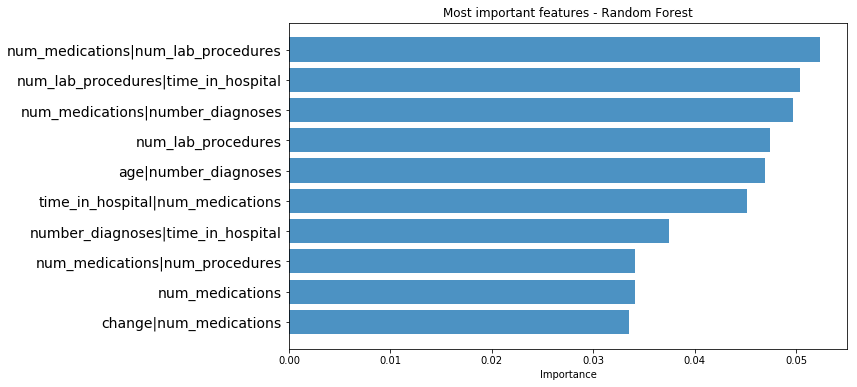

In [73]:
# Create list of top most features based on importance
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest')
plt.show()